In [ ]:
# Comment the following lines if you're not in colab:
from google.colab import drive
drive.mount('/content/drive')
# If you're in colab, cd to your own working directory here:
%cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-7

In [ ]:
import torch as tc
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.distributions import Normal
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

seed = 42
tc.manual_seed(42)
tc.set_default_dtype(tc.float32)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"using {device}")

using cuda


Same as in the previous notebook:

In [ ]:
def get_mask(dim, orientation=True):
    return ((1 - tc.arange(dim) % 2) ^ orientation).float()

In [ ]:
class CouplingLayer(nn.Module):

  def __init__(self, inpt_dim, hid_dim, mask, n_layers=4):
    super().__init__()

    self.odd_mask = mask
    self.even_mask = 1 - self.odd_mask
    self.slope = 0.2

    modules = [
        nn.Linear(inpt_dim, hid_dim),
        # nn.LeakyReLU(self.slope),
        nn.ReLU(),
    ]

    for _ in range(n_layers - 2):
        modules.append(nn.Linear(hid_dim, hid_dim))
        # modules.append(nn.LeakyReLU(self.slope))
        modules.append(nn.ReLU())
    modules.append(nn.Linear(hid_dim, inpt_dim))

    self.m = nn.Sequential(*modules)

  def forward(self, x):
      x1 = self.odd_mask * x
      x2 = self.even_mask * x
      y1 = x1
      y2 = x2 + (self.m(x1) * self.even_mask)
      return y1 + y2

  # Inverse mapping:
  def inverse(self, x):
    y1 = self.odd_mask * x
    y2 = self.even_mask * x
    x1 = y1
    x2 = y2 - (self.m(y1) * self.even_mask)
    return x1 + x2

## <u>Scaling layer</u>

+ **Definition**: The scaling layer is also a flow, and just applies an exponential multiplicative factor to each dimension/component of $z$. I.e., each component $z_i$ of the latent vector $z$ is scaled by a factor $e^{-\theta_i}$, where $\theta_i$ is a learnable parameter. This is a low-cost addition that increases the model's flexibility by allowing different scale factors for different dimensions of the data:

\begin{equation*}
    y = \exp(-\theta) \odot x, \ \theta = \theta_1, \dots, \theta_d.
\end{equation*}

+ **Inverse**: Remember, since we are building a flow model, this transformation has to be invertible (which it is), so, we also have to implement its inverse step:

\begin{equation*}
    x = \exp(\theta) \odot y, \ \theta = \theta_1, \dots, \theta_d.
\end{equation*}

+ **Impact on Likelihoods**: However, we need to account for the impact of this transformation in order to correctly estimate again the log-likelihoods, because the density of the data changes.
+ **Role of the Jacobian**: The determinant of the Jacobian $\det(J)$ comes into play in order for us to account for this change in density. The Jacobian matrix represents the gradients of each component of the transformed vector $z$ w.r.t. each component of $x$. So, $det(J)$ essentially tells us how a small volume around $x$ is scaled when transformed into $z$.
+ **Change of Variables**: The change of variables formula for probability densities requires that we adjust the log-likelihood of $z$ by adding the logarithm of the absolute value of the Jacobian determinant. This adjustment ensures that the transformed log-likelihood reflects the true density of $z$ in the latent space:
\begin{equation}
\log \left( p_Z(z) \right) = \log \left( p_X(x) \right) + \log \left| \det(J) \right|.
\end{equation}
+ **Scaling Layer Case**: In the case of the scaling layer, the Jacobian is diagonal because each dimension of $x$ is scaled independently, and thus the determinant is simply the product of the scaling factors. Since the logarithm is a monotonic transformation, then $\log(\det(J))$ can be computed as the sum of the logarithms of the individual scale factors, which simplifies to the sum of all $-\theta_i$ (so we can still go for exact likelihood calculation efficiently):
\begin{equation}
\sum_i \log \exp (-\theta_i) = \sum_i -\theta_i
\end{equation}

+ **Initialization**:In the paper, it doesn't detail the initialization for the scaling factors specifically. The more standard/expected initialization with `tc.randn` may lead to large initial scaling factors, so we chose values closer to zero in this case (because $e^0 = 1$) for a more stable starting point to reduce the risk of exploding/vanishing values early in the training.

Here is an implementation of the scaling layer:

In [ ]:
class ScalingLayer(nn.Module):
  def __init__(self, inpt_dim):
    super().__init__()
    # theta_i:
    self.log_scale_vector = nn.Parameter(tc.zeros(1, inpt_dim, requires_grad=True))

  def forward(self, x):
    # log(det(J)):
    log_det_jacobian = tc.sum(self.log_scale_vector)
    # Apply scaling to input:
    scaled_x = tc.exp(self.log_scale_vector) * x
    return scaled_x, log_det_jacobian

  def inverse(self, x):
    # We do not need the jacobian for the inverse:
    return tc.exp(-self.log_scale_vector) * x

## <u>Architecture (Gaussian Prior & Scaling)</u>

In [ ]:
class AlmostNICE(nn.Module):
  def __init__(self, inpt_dim, hid_dim=1000, n_coupling_layers=4, n_layers=5):
    super().__init__()

    self.input_dim = inpt_dim
    self.hidden_dim = hid_dim
    self.num_coupling_layers = n_coupling_layers
    self.num_layers = n_layers
    self.prior = Normal(0, 1)

    # alternating mask orientations for consecutive coupling layers
    masks = [
        get_mask(inpt_dim, orientation=(i % 2 == 0)).to(device)
        for i in range(n_coupling_layers)
    ]
    self.coupling_layers = nn.ModuleList([
        CouplingLayer(
            inpt_dim=inpt_dim,
            hid_dim=hid_dim,
            mask=masks[i],
            n_layers=n_layers
        )
        for i in range(n_coupling_layers)
    ])
    # Final layer scales the latent space:
    self.scaling_layer = ScalingLayer(inpt_dim=inpt_dim)

  def forward(self, x):
    z = x
    for i in range(len(self.coupling_layers)):
      z = self.coupling_layers[i](z)
    # Also pass through scaling layer:
    z, log_det_jacobian = self.scaling_layer(z)
    # And add log(det(J)) to the log-likelihood from change of variables:
    log_likel = tc.sum(self.prior.log_prob(z), dim=1) + log_det_jacobian
    return z, log_likel

  def inverse(self, z):
    x = z
    # Inverse, so firstly pass through scaling layer:
    x = self.scaling_layer.inverse(x)
    # And then pass through each coupling layer in reversed order:
    for i in reversed(range(len(self.coupling_layers))):
      x = self.coupling_layers[i].inverse(x)
    return x

  def sample(self, num_samples):
    z = self.prior.sample([num_samples, self.input_dim]).view(num_samples, self.input_dim).to(device)
    return self.inverse(z)

The rest of the code is exactly the same as in the previous notebook:

In [ ]:
length, height = 28, 28   # input size (MNIST)
input_dim = length * height
hidden_dim = 1000         # output size of the hidden layers
num_coupling_layers = 4   # number of coupling layers
num_layers = 5            # number of linear layers for each coupling layer

epochs = 30  # original paper: 1500
batch_size = 128
betas = (0.9, 0.01)
eps = 1e-4
lr = 1e-3

In [ ]:
# Define a custom transform class:
class DequantizeAndScale(tc.nn.Module):
    def __init__(self, scale_range=(0, 1)):
        super().__init__()
        self.scale_range = scale_range

    def forward(self, img):
        # Dequantize by adding uniform noise
        img = img + tc.rand_like(img) / 256.0
        # Scale to desired range, e.g., [0, 1]
        min_val, max_val = self.scale_range
        img = img * (max_val - min_val) + min_val
        return img

# Use the custom transform in a Compose with ToTensor
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    DequantizeAndScale(scale_range=(0, 1))
])

In [ ]:
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform_pipeline)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

We find $28*28=784$ more trainable parameters than previously due to the scaling layer:

In [ ]:
model = AlmostNICE(
    inpt_dim=input_dim,
    n_coupling_layers=num_coupling_layers,
    n_layers=num_layers
).to(device)
# may not work in colab:
_ = summary(model=model)

Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─CouplingLayer: 2-1                --
|    |    └─Sequential: 3-1              4,572,784
|    └─CouplingLayer: 2-2                --
|    |    └─Sequential: 3-2              4,572,784
|    └─CouplingLayer: 2-3                --
|    |    └─Sequential: 3-3              4,572,784
|    └─CouplingLayer: 2-4                --
|    |    └─Sequential: 3-4              4,572,784
├─ScalingLayer: 1-2                      784
Total params: 18,291,920
Trainable params: 18,291,920
Non-trainable params: 0


## <u>Reconstruction (forward -> inverse) sanity check:</u>

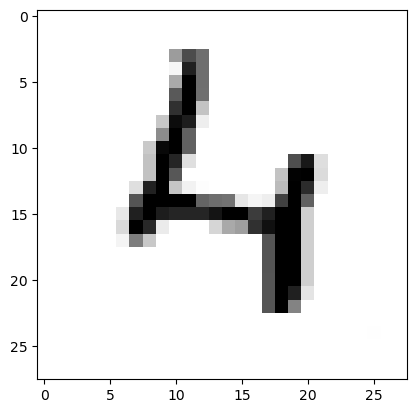

In [ ]:
def reconstruction():
    x_batch, _ = next(iter(train_loader))
    x_batch = x_batch.to(device).view(-1, input_dim)

    out, _ = model(x_batch)
    x_hat = model.inverse(out)

    plt.figure()
    plt.imshow(x_hat[0].detach().cpu().numpy().reshape(height, length), cmap='binary')
    plt.show()

reconstruction()

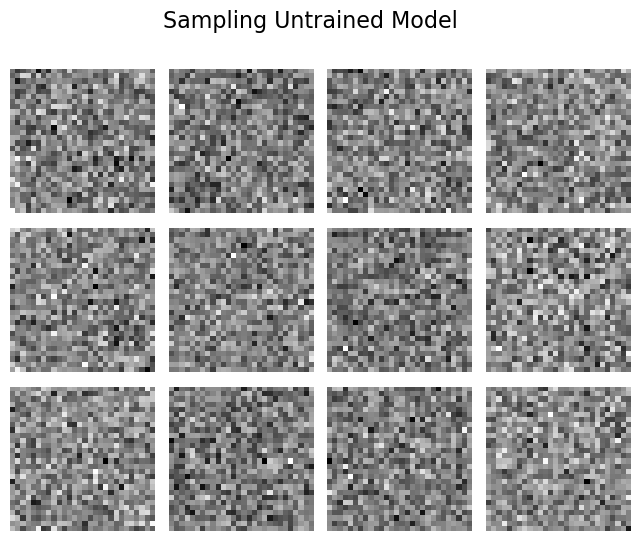

In [ ]:
def sample_model(n_samples=12, title="None"):
    # Model sampling happens here:
    x_hat = model.sample(n_samples)
    x_hat = x_hat.cpu().detach().numpy().reshape(n_samples, 28, 28)
    # The rest is just plotting:
    n_rows = (n_samples + 3) // 4
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=4,
        figsize=(8, 2*n_rows),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, ax in enumerate(axs.flat[:n_samples]):
        ax.imshow(x_hat[i], cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

model.eval()
sample_model(n_samples=12, title="Sampling Untrained Model")

469it [00:14, 31.58it/s]


Epoch 1/30 |  Mean NLL (Loss): 565.6822


469it [00:14, 33.03it/s]


Epoch 2/30 |  Mean NLL (Loss): 211.4030


469it [00:14, 32.68it/s]


Epoch 3/30 |  Mean NLL (Loss): -115.9047


469it [00:14, 32.79it/s]


Epoch 4/30 |  Mean NLL (Loss): -389.1515


469it [00:14, 32.43it/s]


Epoch 5/30 |  Mean NLL (Loss): -597.4723


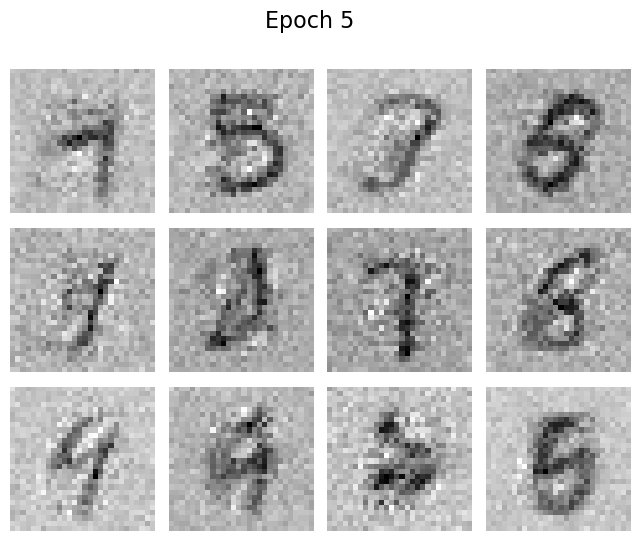

469it [00:14, 32.56it/s]


Epoch 6/30 |  Mean NLL (Loss): -766.7666


469it [00:14, 33.09it/s]


Epoch 7/30 |  Mean NLL (Loss): -895.6554


469it [00:14, 32.69it/s]


Epoch 8/30 |  Mean NLL (Loss): -999.5812


469it [00:14, 32.89it/s]


Epoch 9/30 |  Mean NLL (Loss): -1094.0175


469it [00:14, 32.66it/s]


Epoch 10/30 |  Mean NLL (Loss): -1158.0873


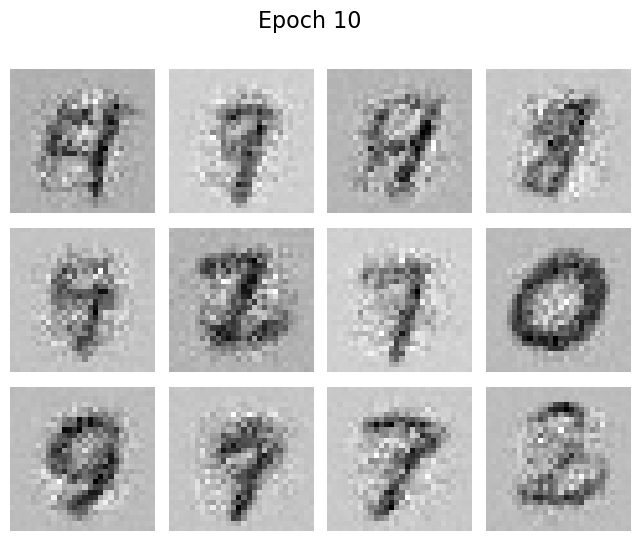

469it [00:14, 32.78it/s]


Epoch 11/30 |  Mean NLL (Loss): -1189.1030


469it [00:14, 32.65it/s]


Epoch 12/30 |  Mean NLL (Loss): -1204.4723


469it [00:14, 33.28it/s]


Epoch 13/30 |  Mean NLL (Loss): -1217.5364


469it [00:14, 33.21it/s]


Epoch 14/30 |  Mean NLL (Loss): -1221.4147


469it [00:14, 33.24it/s]


Epoch 15/30 |  Mean NLL (Loss): -1227.1299


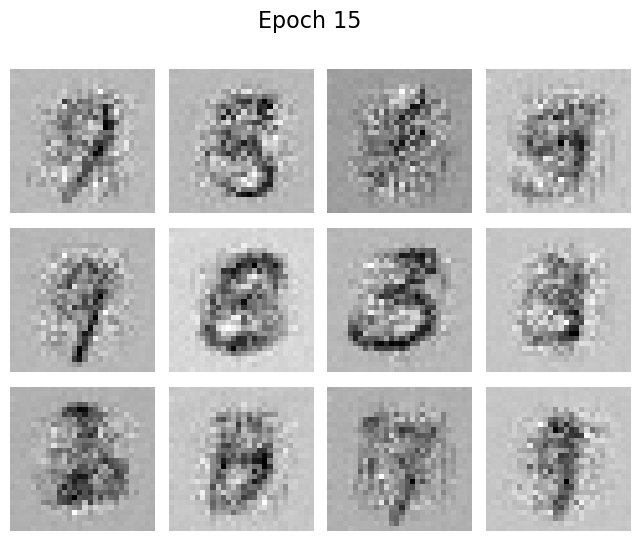

469it [00:14, 32.55it/s]


Epoch 16/30 |  Mean NLL (Loss): -1238.1564


469it [00:14, 33.08it/s]


Epoch 17/30 |  Mean NLL (Loss): -1242.2938


469it [00:14, 32.72it/s]


Epoch 18/30 |  Mean NLL (Loss): -1247.5110


469it [00:14, 33.00it/s]


Epoch 19/30 |  Mean NLL (Loss): -1254.0538


469it [00:14, 33.04it/s]


Epoch 20/30 |  Mean NLL (Loss): -1257.2915


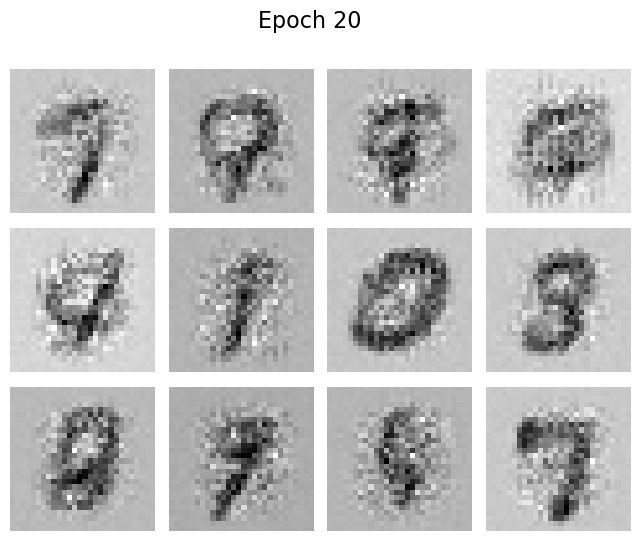

469it [00:14, 32.36it/s]


Epoch 21/30 |  Mean NLL (Loss): -1259.6084


469it [00:14, 32.49it/s]


Epoch 22/30 |  Mean NLL (Loss): -1266.6984


469it [00:14, 32.29it/s]


Epoch 23/30 |  Mean NLL (Loss): -1270.6841


469it [00:14, 32.11it/s]


Epoch 24/30 |  Mean NLL (Loss): -1275.4733


469it [00:14, 32.47it/s]


Epoch 25/30 |  Mean NLL (Loss): -1281.8997


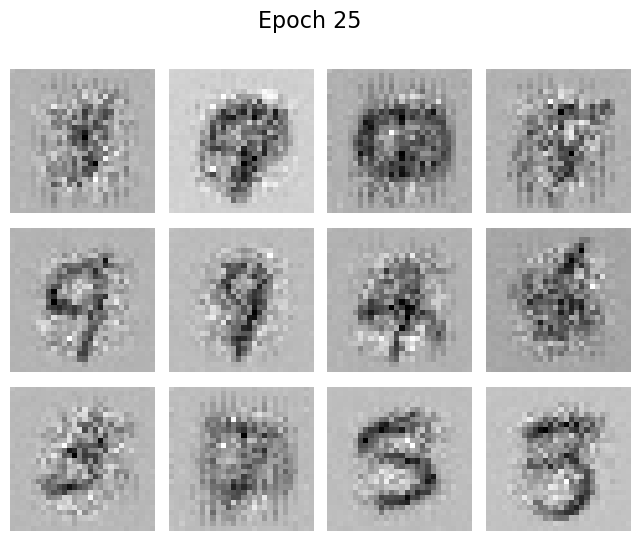

469it [00:14, 33.43it/s]


Epoch 26/30 |  Mean NLL (Loss): -1281.5162


469it [00:14, 32.91it/s]


Epoch 27/30 |  Mean NLL (Loss): -1283.6569


469it [00:14, 32.71it/s]


Epoch 28/30 |  Mean NLL (Loss): -1286.6195


469it [00:14, 32.68it/s]


Epoch 29/30 |  Mean NLL (Loss): -1287.9324


469it [00:14, 32.50it/s]


Epoch 30/30 |  Mean NLL (Loss): -1290.2707


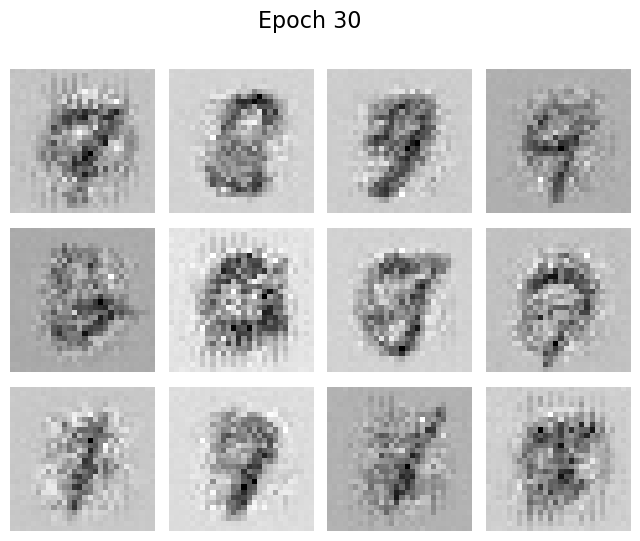

In [ ]:
def train_loop():

    print_every = 5
    optimizer = Adam(params=model.parameters(), lr=lr, betas=betas, eps=eps)
    # Put model in training mode:
    model.train()
    # Main training loop:
    losses_ = np.zeros(epochs)

    for epoch in range(epochs):
        tot_mean_nll = 0.0

        for batch_id, (x, _) in tqdm(enumerate(train_loader)):
            # Zero gradients:
            model.zero_grad()
            # Move to device and flatten:
            x = x.to(device).view(-1, input_dim)
            # Call model:
            _, log_likelihood = model(x)
            # Compute mean NLL loss:
            loss = -tc.mean(log_likelihood)
            # Backpropagate:
            loss.backward()
            # Gradient clipping:
            tc.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
            # Update weights:
            optimizer.step()
            # Add loss:
            tot_mean_nll += loss.item()

        # Take the mean over each epoch and print:
        mean_nll = tot_mean_nll / len(train_loader)
        losses_[epoch] = mean_nll
        print(f'Epoch {epoch+1}/{epochs} |  Mean NLL (Loss): {mean_nll:.4f}')
        if (epoch + 1) % print_every == 0:
            model.eval()
            sample_model(n_samples=12, title=f"Epoch {epoch + 1}")
            model.train()

    return losses_

losses = train_loop()

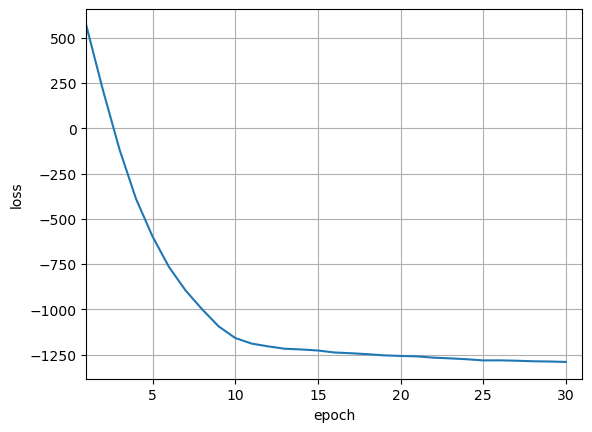

In [ ]:
epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
plt.figure()
plt.plot(epoch_ax, losses)
plt.xlim([1, epochs+1])
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()
plt.close()